In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import models, datasets
import torchvision.transforms as transforms
import os
import torch.quantization
import torch.quantization._numeric_suite as ns
from torch.quantization import (
    default_eval_fn,
    default_qconfig,
    quantize,
)

In [ ]:
# !pip install ultralytics

In [ ]:
from ultralytics import YOLO

In [ ]:
model_origin = YOLO('./models/best.pt')

In [ ]:
# model_origin_quant = YOLO('./models/best_quantized.pt')
checkpoint = torch.load('./models/best_quantized.pt')


In [ ]:
# model_origin.state_dict()

In [ ]:
checkpoint.state_dict()

AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'

In [ ]:
# float_model = torchvision.models.quantization.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1, quantize=False)
# float_model.to('cpu')
# float_model.eval()
# float_model.fuse_model()
# float_model.qconfig = torch.quantization.default_qconfig
# img_data = [(torch.rand(2, 3, 10, 10, dtype=torch.float), torch.randint(0, 1, (2,), dtype=torch.long)) for _ in range(2)]
# qmodel = quantize(float_model, default_eval_fn, [img_data], inplace=False)




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.6MB/s]


In [ ]:
wt_compare_dict = ns.compare_weights(float_model.state_dict(), qmodel.state_dict())

print('keys of wt_compare_dict:')
print(wt_compare_dict.keys())

print("\nkeys of wt_compare_dict entry for conv1's weight:")
print(wt_compare_dict['conv1.weight'].keys())
print(wt_compare_dict['conv1.weight']['float'].shape)
print(wt_compare_dict['conv1.weight']['quantized'].shape)

keys of wt_compare_dict:
dict_keys(['conv1.weight', 'layer1.0.conv1.weight', 'layer1.0.conv2.weight', 'layer1.1.conv1.weight', 'layer1.1.conv2.weight', 'layer2.0.conv1.weight', 'layer2.0.conv2.weight', 'layer2.0.downsample.0.weight', 'layer2.1.conv1.weight', 'layer2.1.conv2.weight', 'layer3.0.conv1.weight', 'layer3.0.conv2.weight', 'layer3.0.downsample.0.weight', 'layer3.1.conv1.weight', 'layer3.1.conv2.weight', 'layer4.0.conv1.weight', 'layer4.0.conv2.weight', 'layer4.0.downsample.0.weight', 'layer4.1.conv1.weight', 'layer4.1.conv2.weight', 'fc._packed_params._packed_params'])

keys of wt_compare_dict entry for conv1's weight:
dict_keys(['float', 'quantized'])
torch.Size([64, 3, 7, 7])
torch.Size([64, 3, 7, 7])


In [ ]:
def compute_error(x, y):
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)

for key in wt_compare_dict:
    print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))

conv1.weight tensor(31.6638)
layer1.0.conv1.weight tensor(30.6450)
layer1.0.conv2.weight tensor(31.1528)
layer1.1.conv1.weight tensor(32.1438)
layer1.1.conv2.weight tensor(31.2477)
layer2.0.conv1.weight tensor(30.9890)
layer2.0.conv2.weight tensor(28.8233)
layer2.0.downsample.0.weight tensor(31.5558)
layer2.1.conv1.weight tensor(30.7668)
layer2.1.conv2.weight tensor(28.4516)
layer3.0.conv1.weight tensor(30.9247)
layer3.0.conv2.weight tensor(26.6841)
layer3.0.downsample.0.weight tensor(28.7825)
layer3.1.conv1.weight tensor(28.9707)
layer3.1.conv2.weight tensor(25.6784)
layer4.0.conv1.weight tensor(26.8495)
layer4.0.conv2.weight tensor(25.8394)
layer4.0.downsample.0.weight tensor(28.6355)
layer4.1.conv1.weight tensor(26.8758)
layer4.1.conv2.weight tensor(28.4319)
fc._packed_params._packed_params tensor(32.6505)


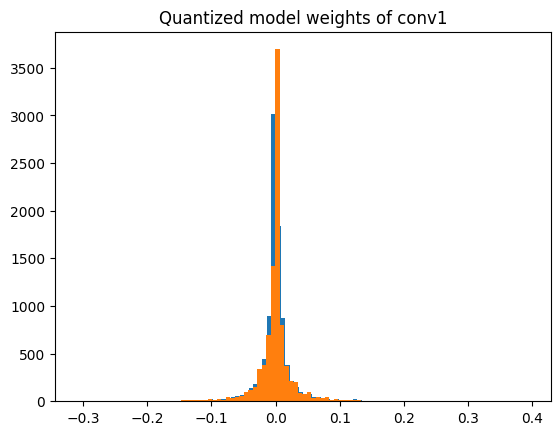

In [ ]:
import matplotlib.pyplot as plt

f = wt_compare_dict['conv1.weight']['float'].flatten()
plt.hist(f, bins = 100)
plt.title("Floating point model weights of conv1")
# plt.show()

q = wt_compare_dict['conv1.weight']['quantized'].flatten().dequantize()
plt.hist(q, bins = 100)
plt.title("Quantized model weights of conv1")
plt.show()

In [ ]:
data = img_data[0][0]

# Take in floating point and quantized model as well as input data, and returns a dict, with keys
# corresponding to the quantized module names and each entry being a dictionary with two keys 'float' and
# 'quantized', containing the activations of floating point and quantized model at matching locations.
act_compare_dict = ns.compare_model_outputs(float_model, qmodel, data)

print('keys of act_compare_dict:')
print(act_compare_dict.keys())

print("\nkeys of act_compare_dict entry for conv1's output:")
print(act_compare_dict['conv1.stats'].keys())
print(act_compare_dict['conv1.stats']['float'][0].shape)
print(act_compare_dict['conv1.stats']['quantized'][0].shape)

keys of act_compare_dict:
dict_keys(['conv1.stats', 'layer1.0.conv1.stats', 'layer1.0.conv2.stats', 'layer1.0.add_relu.stats', 'layer1.1.conv1.stats', 'layer1.1.conv2.stats', 'layer1.1.add_relu.stats', 'layer2.0.conv1.stats', 'layer2.0.conv2.stats', 'layer2.0.downsample.0.stats', 'layer2.0.add_relu.stats', 'layer2.1.conv1.stats', 'layer2.1.conv2.stats', 'layer2.1.add_relu.stats', 'layer3.0.conv1.stats', 'layer3.0.conv2.stats', 'layer3.0.downsample.0.stats', 'layer3.0.add_relu.stats', 'layer3.1.conv1.stats', 'layer3.1.conv2.stats', 'layer3.1.add_relu.stats', 'layer4.0.conv1.stats', 'layer4.0.conv2.stats', 'layer4.0.downsample.0.stats', 'layer4.0.add_relu.stats', 'layer4.1.conv1.stats', 'layer4.1.conv2.stats', 'layer4.1.add_relu.stats', 'fc.stats', 'quant.stats'])

keys of act_compare_dict entry for conv1's output:
dict_keys(['float', 'quantized'])
torch.Size([2, 64, 5, 5])
torch.Size([2, 64, 5, 5])


In [ ]:
for key in act_compare_dict:
    print(key, compute_error(act_compare_dict[key]['float'][0], act_compare_dict[key]['quantized'][0].dequantize()))

conv1.stats tensor(37.3626, grad_fn=<MulBackward0>)
layer1.0.conv1.stats tensor(29.9159, grad_fn=<MulBackward0>)
layer1.0.conv2.stats tensor(28.6062, grad_fn=<MulBackward0>)
layer1.0.add_relu.stats tensor(32.1350, grad_fn=<MulBackward0>)
layer1.1.conv1.stats tensor(29.5786, grad_fn=<MulBackward0>)
layer1.1.conv2.stats tensor(26.3322, grad_fn=<MulBackward0>)
layer1.1.add_relu.stats tensor(29.8155, grad_fn=<MulBackward0>)
layer2.0.conv1.stats tensor(26.5730, grad_fn=<MulBackward0>)
layer2.0.conv2.stats tensor(26.5052, grad_fn=<MulBackward0>)
layer2.0.downsample.0.stats tensor(22.7000, grad_fn=<MulBackward0>)
layer2.0.add_relu.stats tensor(25.8668, grad_fn=<MulBackward0>)
layer2.1.conv1.stats tensor(25.6072, grad_fn=<MulBackward0>)
layer2.1.conv2.stats tensor(24.4478, grad_fn=<MulBackward0>)
layer2.1.add_relu.stats tensor(26.0110, grad_fn=<MulBackward0>)
layer3.0.conv1.stats tensor(26.9327, grad_fn=<MulBackward0>)
layer3.0.conv2.stats tensor(26.8181, grad_fn=<MulBackward0>)
layer3.0.downs

In [ ]:
ns.prepare_model_outputs(float_model, qmodel)

for data in img_data:
    float_model(data[0])
    qmodel(data[0])

# Find the matching activation between floating point and quantized modules, and return a dict with key
# corresponding to quantized module names and each entry being a dictionary with two keys 'float'
# and 'quantized', containing the matching floating point and quantized activations logged by the logger
act_compare_dict = ns.get_matching_activations(float_model, qmodel)

In [ ]:
class MyOutputLogger(ns.Logger):
    r"""Customized logger class
    """

    def __init__(self):
        super(MyOutputLogger, self).__init__()

    def forward(self, x):
        # Custom functionalities
        # ...
        return x

In [ ]:
data = img_data[0][0]
act_compare_dict = ns.compare_model_outputs(float_model, qmodel, data, logger_cls=MyOutputLogger)

In [ ]:
float_model = torchvision.models.quantization.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1, quantize=False)
float_model.to('cpu')
float_model.eval()
float_model.fuse_model()
float_model.qconfig = torch.quantization.default_qconfig
img_data = [(torch.rand(2, 3, 10, 10, dtype=torch.float), torch.randint(0, 1, (2,), dtype=torch.long)) for _ in range(2)]
qmodel = quantize(float_model, default_eval_fn, [img_data], inplace=False)

In [ ]:
data = img_data[0][0]
module_swap_list = [torchvision.models.quantization.resnet.QuantizableBasicBlock]

# Takes in floating point and quantized model as well as input data, and returns a dict with key
# corresponding to module names and each entry being a dictionary with two keys 'float' and
# 'quantized', containing the output tensors of quantized module and its matching floating point shadow module.
ob_dict = ns.compare_model_stub(float_model, qmodel, module_swap_list, data)

print('keys of ob_dict:')
print(ob_dict.keys())

print("\nkeys of ob_dict entry for layer1.0's output:")
print(ob_dict['layer1.0.stats'].keys())
print(ob_dict['layer1.0.stats']['float'][0].shape)
print(ob_dict['layer1.0.stats']['quantized'][0].shape)

keys of ob_dict:
dict_keys(['layer1.0.stats', 'layer1.1.stats', 'layer2.0.stats', 'layer2.1.stats', 'layer3.0.stats', 'layer3.1.stats', 'layer4.0.stats', 'layer4.1.stats'])

keys of ob_dict entry for layer1.0's output:
dict_keys(['float', 'quantized'])
torch.Size([64, 3, 3])
torch.Size([64, 3, 3])


In [ ]:
for key in ob_dict:
    print(key, compute_error(ob_dict[key]['float'][0], ob_dict[key]['quantized'][0].dequantize()))

layer1.0.stats tensor(32.8959)
layer1.1.stats tensor(34.3619)
layer2.0.stats tensor(28.7731)
layer2.1.stats tensor(31.7963)
layer3.0.stats tensor(28.5066)
layer3.1.stats tensor(32.0265)
layer4.0.stats tensor(25.6530)
layer4.1.stats tensor(23.1788)
